In [1]:
%pip install -q sklearn 
%pip install -q matplotlib
%pip install -q numpy 
%pip install -q torch 
%pip install -q torchvision

Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Importações

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [3]:
from torch.utils.data import DataLoader, random_split


# Dataset

Transformações para normalizar as imagens

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))  # Normaliza para o intervalo [-1, 1]
])


Carregar o dataset MNIST

In [5]:
train_dataset = datasets.MNIST(
    root="./data", 
    train=True, 
    download=True, 
    transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", 
    train=False, 
    download=True, 
    transform=transform
)

Dividir o conjunto de treino em treino (80%) e validação (20%)

In [6]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


DataLoaders para treino, validação e teste

In [7]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#

## Plotar imagens de exemplo

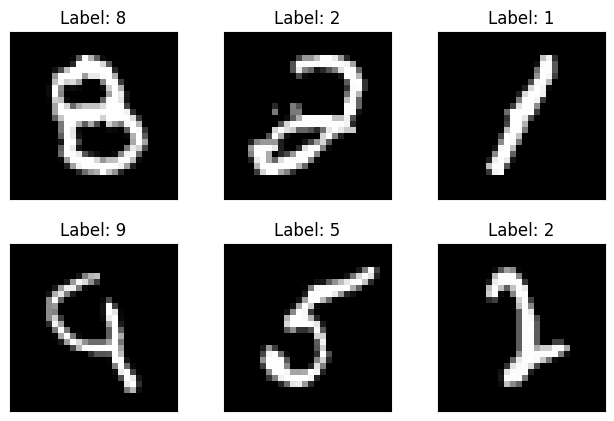

In [8]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Label: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

# Implementação da MLP

In [9]:
class MLP(nn.Module):
    def __init__(self, input_size=28 * 28, num_classes=10):
        super(MLP, self).__init__()

        self.input_size = input_size
        self.num_classes = num_classes

        self.fc1 = nn.Linear(self.input_size, 128)
        self.fc2 = nn.Linear(128, 64)

        self.fc3 = nn.Linear(64, self.num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))

        x = self.fc3(x)  # Não aplicamos softmax aqui pq é feito internamente no CrossEntropyLoss
        return x

Instanciar modelo, função de perda e otimizador

In [10]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Treinar modelo

Funções para calcular acuracia, treinar e validar

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def train(
    model: MLP,
    train_loader: DataLoader,
    criterion: nn.CrossEntropyLoss,
    optimizer: optim.Adam,
):
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss: torch.Tensor = criterion(outputs, labels)

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(outputs, labels)

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    return train_loss, train_acc


def validate(
    model: MLP, 
    data_loader: DataLoader, 
    criterion: nn.CrossEntropyLoss
):
    model.eval()
    val_loss, val_acc = 0.0, 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            loss: torch.Tensor = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += accuracy(outputs, labels)

    val_loss /= len(data_loader)
    val_acc /= len(data_loader)

    return val_loss, val_acc

In [12]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)

    val_loss, val_acc = validate(model, val_loader, criterion)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print()

Epoch [1/10]
Train Loss: 0.4392, Train Acc: 0.8688
Val Loss: 0.2580, Val Acc: 0.9236

Epoch [2/10]
Train Loss: 0.2215, Train Acc: 0.9334
Val Loss: 0.2080, Val Acc: 0.9356

Epoch [3/10]
Train Loss: 0.1621, Train Acc: 0.9510
Val Loss: 0.2038, Val Acc: 0.9358

Epoch [4/10]
Train Loss: 0.1290, Train Acc: 0.9601
Val Loss: 0.1388, Val Acc: 0.9579

Epoch [5/10]
Train Loss: 0.1102, Train Acc: 0.9655
Val Loss: 0.1245, Val Acc: 0.9625

Epoch [6/10]
Train Loss: 0.0943, Train Acc: 0.9711
Val Loss: 0.1140, Val Acc: 0.9673

Epoch [7/10]
Train Loss: 0.0800, Train Acc: 0.9741
Val Loss: 0.1172, Val Acc: 0.9669

Epoch [8/10]
Train Loss: 0.0736, Train Acc: 0.9771
Val Loss: 0.1108, Val Acc: 0.9675

Epoch [9/10]
Train Loss: 0.0658, Train Acc: 0.9788
Val Loss: 0.1224, Val Acc: 0.9653

Epoch [10/10]
Train Loss: 0.0582, Train Acc: 0.9804
Val Loss: 0.1058, Val Acc: 0.9695



## Avaliação no conjunto de teste

In [13]:
test_loss, test_acc = validate(model, test_loader, criterion)

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 0.1025, Test Acc: 0.9698


Exibir previsões

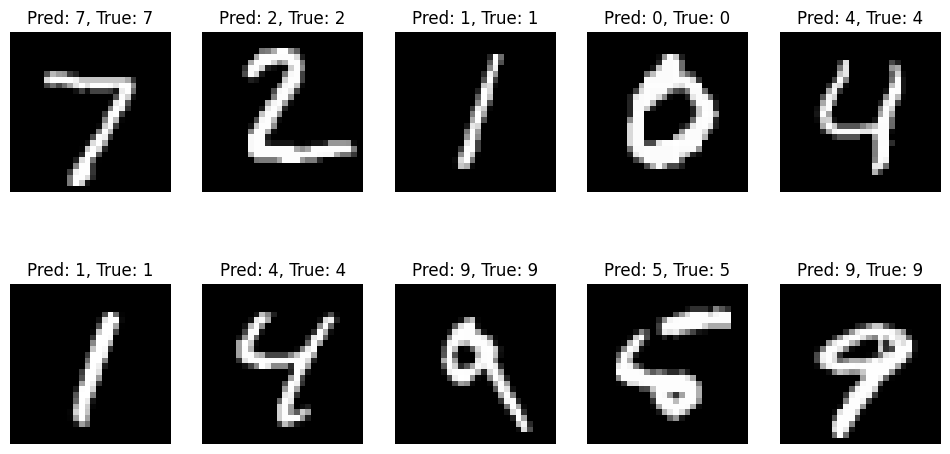

In [16]:
def show_predictions(
    model: MLP, 
    test_loader: DataLoader, 
    num_images=10
):
    model.eval()
    images, labels = next(iter(test_loader))
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(f"Pred: {preds[i]}, True: {labels[i]}")
        plt.axis("off")
    plt.show()


show_predictions(model, test_loader)